In [1]:
import numpy as np
from numba import vectorize
import matplotlib.pyplot as plt
import torch
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj')
from dft3dgpu import dft3d

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-04-27

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4036MB, multi_processor_count=6)


In [3]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

# Defining the fluid properties

In [63]:
# fluid properties
sigma = 1.0
epsilon = 1.0
L = 11.2*sigma
# Temperature and Density 
kT = 2.934
rhob = 0.450
# kT = 2.888
# rhob = 0.850

# Defining the functional 


In [64]:
# Test the HS functional 
Ngrid = 128
DFT = dft3d(gridsize=(Ngrid,Ngrid,Ngrid),ljmethod='MMFA')
DFT.Set_Geometry(L=L)
DFT.Set_FluidProperties(sigma=sigma,epsilon=epsilon)
DFT.Set_Temperature(kT)
DFT.Set_BulkDensity(rhob)

In [65]:
DFT.delta

array([0.0875, 0.0875, 0.0875])

In [66]:
R = np.sqrt(DFT.X**2+DFT.Y**2+DFT.Z**2+1e-16)
Vext = ljpotential(R,epsilon,sigma)
DFT.Set_External_Potential(Vext)

del R

(-5.64375, 5.556250000000046, -5.64375, 5.556250000000046)

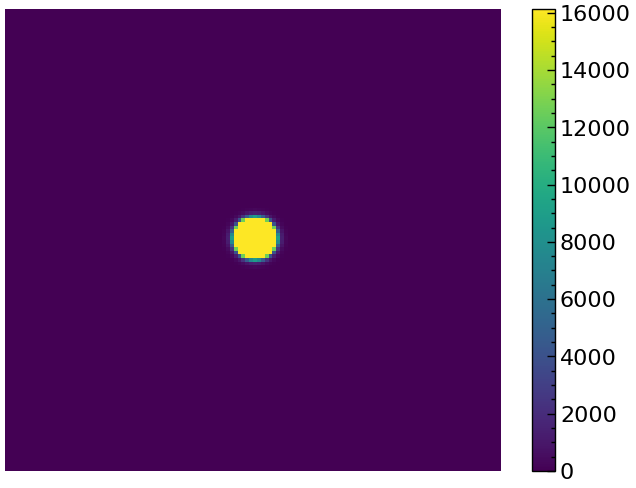

In [67]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis')
plt.colorbar(c)
plt.axis('off')

## Setting the Initial Condition

In [68]:
DFT.Set_InitialCondition()

In [69]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.4500))

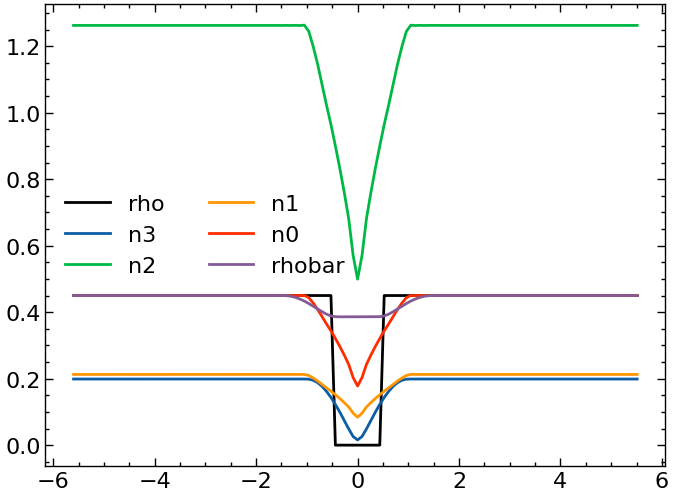

In [70]:
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rho[:,Ngrid//2,Ngrid//2].numpy(),color='k',label='rho')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n3[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n3')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n2[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n2')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n1[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n1')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n0[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n0')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rhobar[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='rhobar')
plt.legend(loc='best',ncols=2)

## Calculate Equilibrium

In [71]:
# DFT.Calculate_Equilibrium(alpha0=0.6,rtol=1e-1,atol=1e-2,max_iter=15,method='picard',logoutput=True)
DFT.Calculate_Equilibrium(alpha0=0.1,dt=0.1,rtol=1e-4,atol=1e-6,method='fire',logoutput=True)

0 -1195.5322 430277.6
1 -2473.4883 56483.566
2 -2530.4287 16174.411
3 -2543.247 7805.57
4 -2548.072 4353.348
5 -2550.3472 2754.7285
6 -2551.589 1837.861
7 -2552.3381 1303.918


/home/elvis/Google Drive/Projetos em Andamento/2-DFT in Amorphous Carbon/codes/PyDFTlj/examples/../src/pydftlj/dft3dgpu.py:179: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = torch.tensor(dphi3dnfuncWBI(self.n3.numpy()),dtype=torch.float32)


8 -2552.824 935.52997
9 -2553.158 672.2822
10 -2553.3916 482.06952
11 -2553.556 343.92145
12 -2553.665 246.61943
13 -2553.7292 180.91301
14 -2553.759 139.33147
15 -2553.772 111.22905
16 -2553.792 70.124115
17 -2553.7861 86.096085
18 -2553.7856 85.98008
19 -2553.7886 82.55292
20 -2553.7922 76.97765
21 -2553.7966 69.483025
22 -2553.8013 60.397747
23 -2553.806 50.158
24 -2553.8098 39.33514
25 -2553.813 28.733746
26 -2553.815 19.737537
27 -2553.815 15.056213
28 -2553.8152 16.607162
29 -2553.815 20.91485
30 -2553.814 24.33546
31 -2553.8145 25.025326
32 -2553.8154 21.556585
33 -2553.8162 11.373391
34 -2553.8164 13.520408
35 -2553.8162 13.384177
36 -2553.8162 13.146882
37 -2553.8162 12.813013
38 -2553.816 12.387055
39 -2553.817 11.874341
40 -2553.816 11.281327
41 -2553.817 10.615003
42 -2553.8164 9.884166
43 -2553.8171 9.097257
44 -2553.8164 8.264927
45 -2553.8167 7.398937
46 -2553.8167 6.5115356
47 -2553.8164 5.617201
48 -2553.8164 4.7336683
49 -2553.817 3.8813264
50 -2553.8171 3.0880845
51 

In [72]:
DFT.Niter

75

In [73]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.7330))

In [74]:
DFT.Omega

tensor(-2553.8164)

(-5.64375, 5.556250000000046, -5.64375, 5.556250000000046)

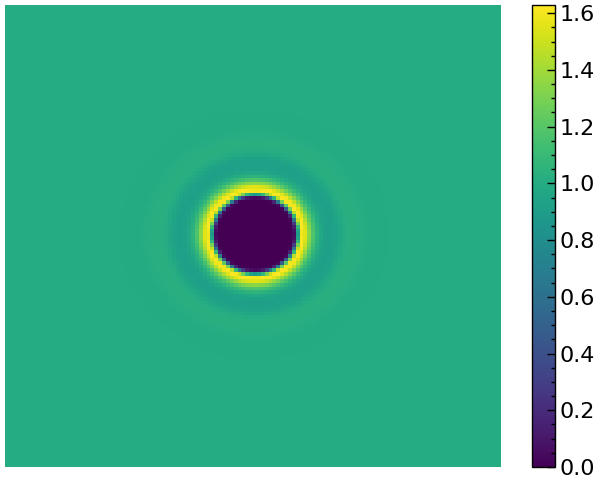

In [75]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.rho[:,:,Ngrid//2].numpy()/rhob, cmap='viridis')
plt.colorbar(c)
plt.axis('off')

In [76]:
np.save(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid={Ngrid}-ljmethod={DFT.ljmethod}.npy',(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob))

## Plotting g(r)

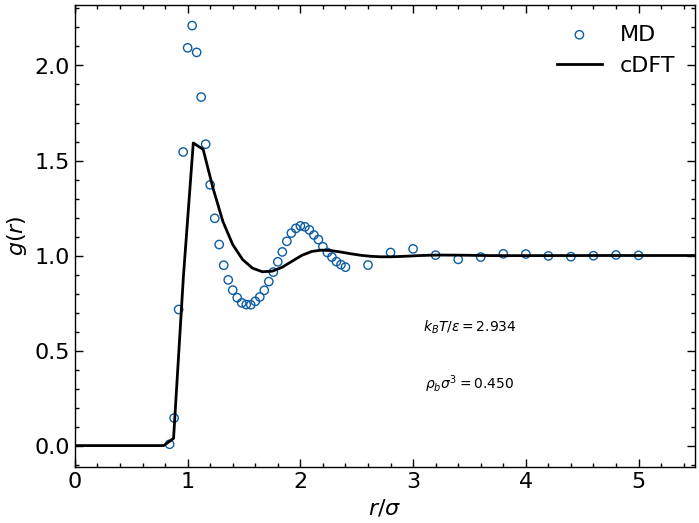

: 

In [77]:
import pandas as pd
df = pd.read_excel('data/MC/MCdata-radialdistribution-lennardjones-Verlet1968.xls',sheet_name='rhob=0.850')
plt.scatter(df['r'],df['KT=2.888'],marker='o',edgecolors='C0',facecolors='none',label='MD')
plt.plot(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob,'-',color='k',label=r'cDFT')
plt.xlim(0.0,5.5)
# plt.ylim(0,2.0)
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.text(3.5,0.6,r'$k_B T/\epsilon = 2.934$',ha='center')
plt.text(3.5,0.3,r'$\rho_b \sigma^3 = 0.450$',ha='center')
plt.legend(loc='upper right',ncol=1)